# Project: Cross-Asset Signals for FX Futures Trading

- **Course**: FINM 33150 Quantitative Trading Strategies
- **Due Date**: 07 March 2026
- **Group**: N
- **Researchers**:
    - Adith Srinivasan - 12255557
    - Andrew Moukabary - 12311312
    - Cole Koryto - 12506473
    - Jonathan Kim - 12506556
    - Scott Hanna - 12496698

# Preliminaries

Includes required package imports, global constants, and all function definitions. Collapsed for readability.

In [ ]:
import warnings
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import plotnine as p9
from plotnine import (
    ggplot,
    aes,
    geom_line,
    facet_wrap,
    labs,
    theme_bw,
    theme_minimal,
    element_text,
    theme,
    theme_gray,
)

import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(0, str(Path("..").resolve()))
from src.fx_data import load_fx_spot
from src.fx_spot_data_exploration_plots import build_all_fx_spot_plots


# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotnine theme for better aesthetics
p9.theme_set(p9.theme_gray())

# Set matplotlib parameters for better aesthetics
mpl.rcParams["figure.edgecolor"] = "none"
mpl.rcParams["savefig.transparent"] = True

# Reset matplotlib parameters to default for any plots that follow
# plt.rcdefaults()


In [44]:
START_DATE = "2024-01-01"
END_DATE = "2026-02-20"

In [45]:
DATA_DIR = Path("../data")
print(DATA_DIR)

../data


## Data Preparation

In [46]:
def prepare_bbg_data(data: pd.DataFrame):

    data = data.copy()

    data = data.rename(columns={"Dates": "date"})

    data["date"] = pd.to_datetime(data["date"])
    data = data.set_index("date")

    data = data[
        (data.index > pd.to_datetime(START_DATE))
        & (data.index < pd.to_datetime(END_DATE))
    ]

    data = data.ffill()
    data = data.dropna()

    return data

In [47]:
def plot_rebased_equity_indices(df: pd.DataFrame):
    # If your dates are the index (like in your screenshot), make it a column
    if df.index.name in ("date", "Dates") or isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()

    # Standardize column name
    if "Dates" in df.columns and "date" not in df.columns:
        df = df.rename(columns={"Dates": "date"})

    df["date"] = pd.to_datetime(df["date"])

    df_rebased = df.copy()
    for col in df.columns:
        if col != "date":
            df_rebased[col] = df[col] / df[col].iloc[0] * 100

    # Melt to long
    df_long = df_rebased.melt(id_vars="date", var_name="Index", value_name="Level")

    # Force numeric (handles strings, commas, weird Excel types)
    df_long["Level"] = pd.to_numeric(df_long["Level"], errors="coerce")

    # Drop unusable rows
    df_long = df_long.dropna(subset=["date", "Level"])

    # Plot
    p = (
        ggplot(df_long, aes(x="date", y="Level", color="Index"))
        + geom_line(size=1)
        + theme_minimal()
        + labs(
            title="Equity Indices Over Time",
            x="Date",
            y="Rebased Index Level (Base = 100)",
        )
        + theme(
            figure_size=(12, 6),
            legend_title=element_text(size=10),
            legend_text=element_text(size=9),
        )
    )

    display(p)

In [48]:
def plot_cds_data(df: pd.DataFrame):

    # If your dates are the index (like in your screenshot), make it a column
    if df.index.name in ("date", "Dates") or isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()

    # Standardize column name
    if "Dates" in df.columns and "date" not in df.columns:
        df = df.rename(columns={"Dates": "date"})

    # Ensure datetime
    df["date"] = pd.to_datetime(df["date"])

    # Wide → long
    df_long = df.melt(id_vars="date", var_name="CDS", value_name="Spread")

    df_long["Spread"] = pd.to_numeric(df_long["Spread"], errors="coerce")
    df_long = df_long.dropna()

    # Combined plot
    p_all = (
        ggplot(df_long, aes("date", "Spread", color="CDS"))
        + geom_line(size=1)
        + theme_gray()
        + labs(title="CDS Spreads Over Time", x="Date", y="Spread (bps)")
        + theme(figure_size=(14, 6))
    )

    display(p_all)

    for col in df.columns:
        if col != "date":
            p = (
                ggplot(df, aes("date", col))
                + geom_line(size=1, color="steelblue")
                + theme_gray()
                + labs(title=f"{col} Over Time", x="Date", y="Spread (bps)")
                + theme(figure_size=(12, 4))
            )

            display(p)

# Abstract

This paper develops a two-stage framework to forecast exchange rate movements using credit and equity market information. In the first stage, exchange rate changes are regressed on foreign sovereign CDS spreads to remove the portion of currency movements driven by broad macro and risk conditions that affect both credit and FX markets. The resulting residual represents exchange rate variation not explained by these common macro factors.

In the second stage, this residual FX componen in regressed on excess foreign equity returns to isolate the equity-driven effect on currencies. The estimated relationship produces a trading signal, and currency futures positions are taken when the signal is sufficiently strong. The framework tests whether controlling for macro risk improves the predictive link between equity performance and exchange rate movements.

# Keywords

- Exchange rate predictability 
- Cross-asset return forecasting 
- Sovereign CDS spreads 
- Equity–FX linkage 
- Residual-based signal extraction 
- Currency futures 


# 1. Introduction

Global capital markets are highly interconnected, and cross-border flows of equity and credit capital can have substantial effects on exchange rates. Our strategy exploits the intuition that country-specific equity performance can provide predictive information about currency movements, once the influence of broad macroeconomic and global risk factors is removed. The underlying idea is that when investors reallocate capital in response to strong equity returns in a foreign market, they must transact in the local currency of that market. If these flows are sufficiently large or concentrated, they can drive meaningful movements in exchange rates.

However, exchange rates are influenced not only by equity-driven flows but also by macroeconomic and global risk factors that affect multiple asset classes simultaneously. For example, broad risk sentiment or systemic credit conditions can move both sovereign CDS spreads and currencies. To isolate the portion of FX movements specifically related to equity-driven capital flows, we introduce a two-stage regression framework.

In the first stage, we regress exchange rate changes on foreign sovereign CDS spreads. Sovereign CDS spreads are sensitive to macroeconomic and global risk conditions — including interest rate expectations, fiscal risk, and systemic shocks — which often simultaneously affect currency markets. By regressing FX on CDS, we remove the component of exchange rate movements that is correlated with these macro risk factors. The residual from this regression represents the portion of currency movements that is orthogonal to broad macro conditions, effectively filtering out “noise” from global risk factors and leaving the variation potentially attributable to other forces, such as equity-driven capital flows.

In the second stage, we regress the residual FX component against the excess foreign equity returns. The intuition is that equity performance can drive short-term currency demand through portfolio reallocation. If a country’s equities outperform relative to domestic and global markets, investors may increase exposure to that market, purchasing the local currency to execute their trades. By regressing the residual FX variation on excess equity returns, we identify the equity-driven signal that is not explained by broad macro factors. The fitted relationship from this stage serves as the trading signal in our strategy: positions in currency futures are initiated when the signal exceeds a predetermined threshold, reflecting a sufficiently strong equity-driven push on the currency.

Overall, our strategy integrates credit, equity, and FX markets into a unified predictive framework, exploiting the residual information in FX markets after conditioning on macro factors. It is designed to capture mispricings in currency futures driven by equity performance, while controlling for broader macro and risk-related influences that could confound the signal. By focusing on the portion of currency variation that is truly driven by equity performance, our approach aims to generate actionable signals with improved predictive power and reduced exposure to global shocks.

## Data

### FX Spot Data

Plot: indexed_spot_rates


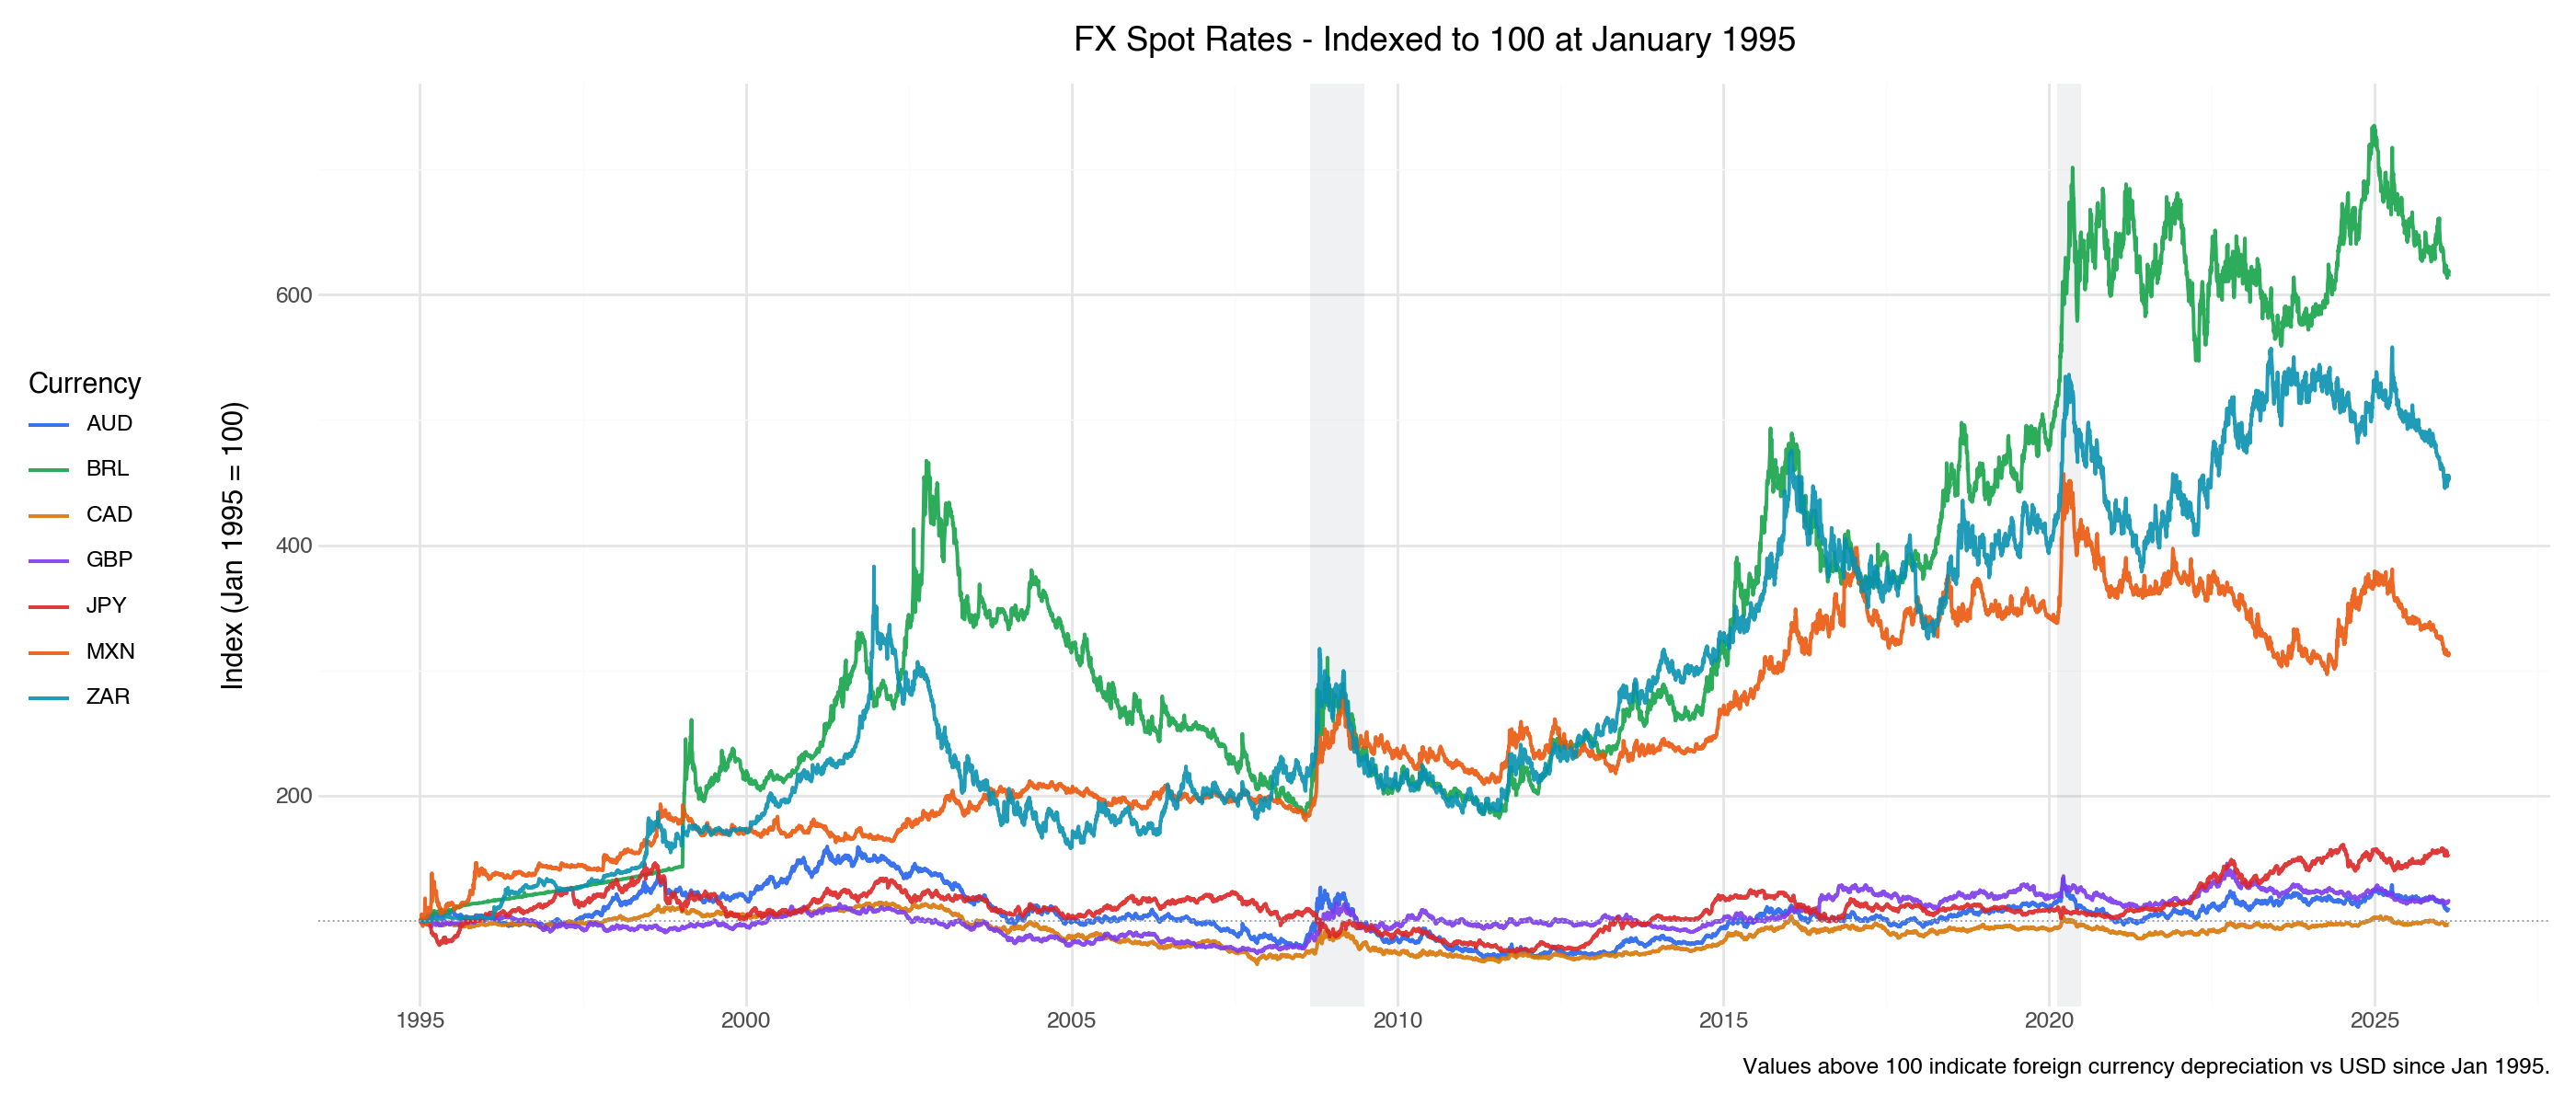

Plot: absolute_spot_levels


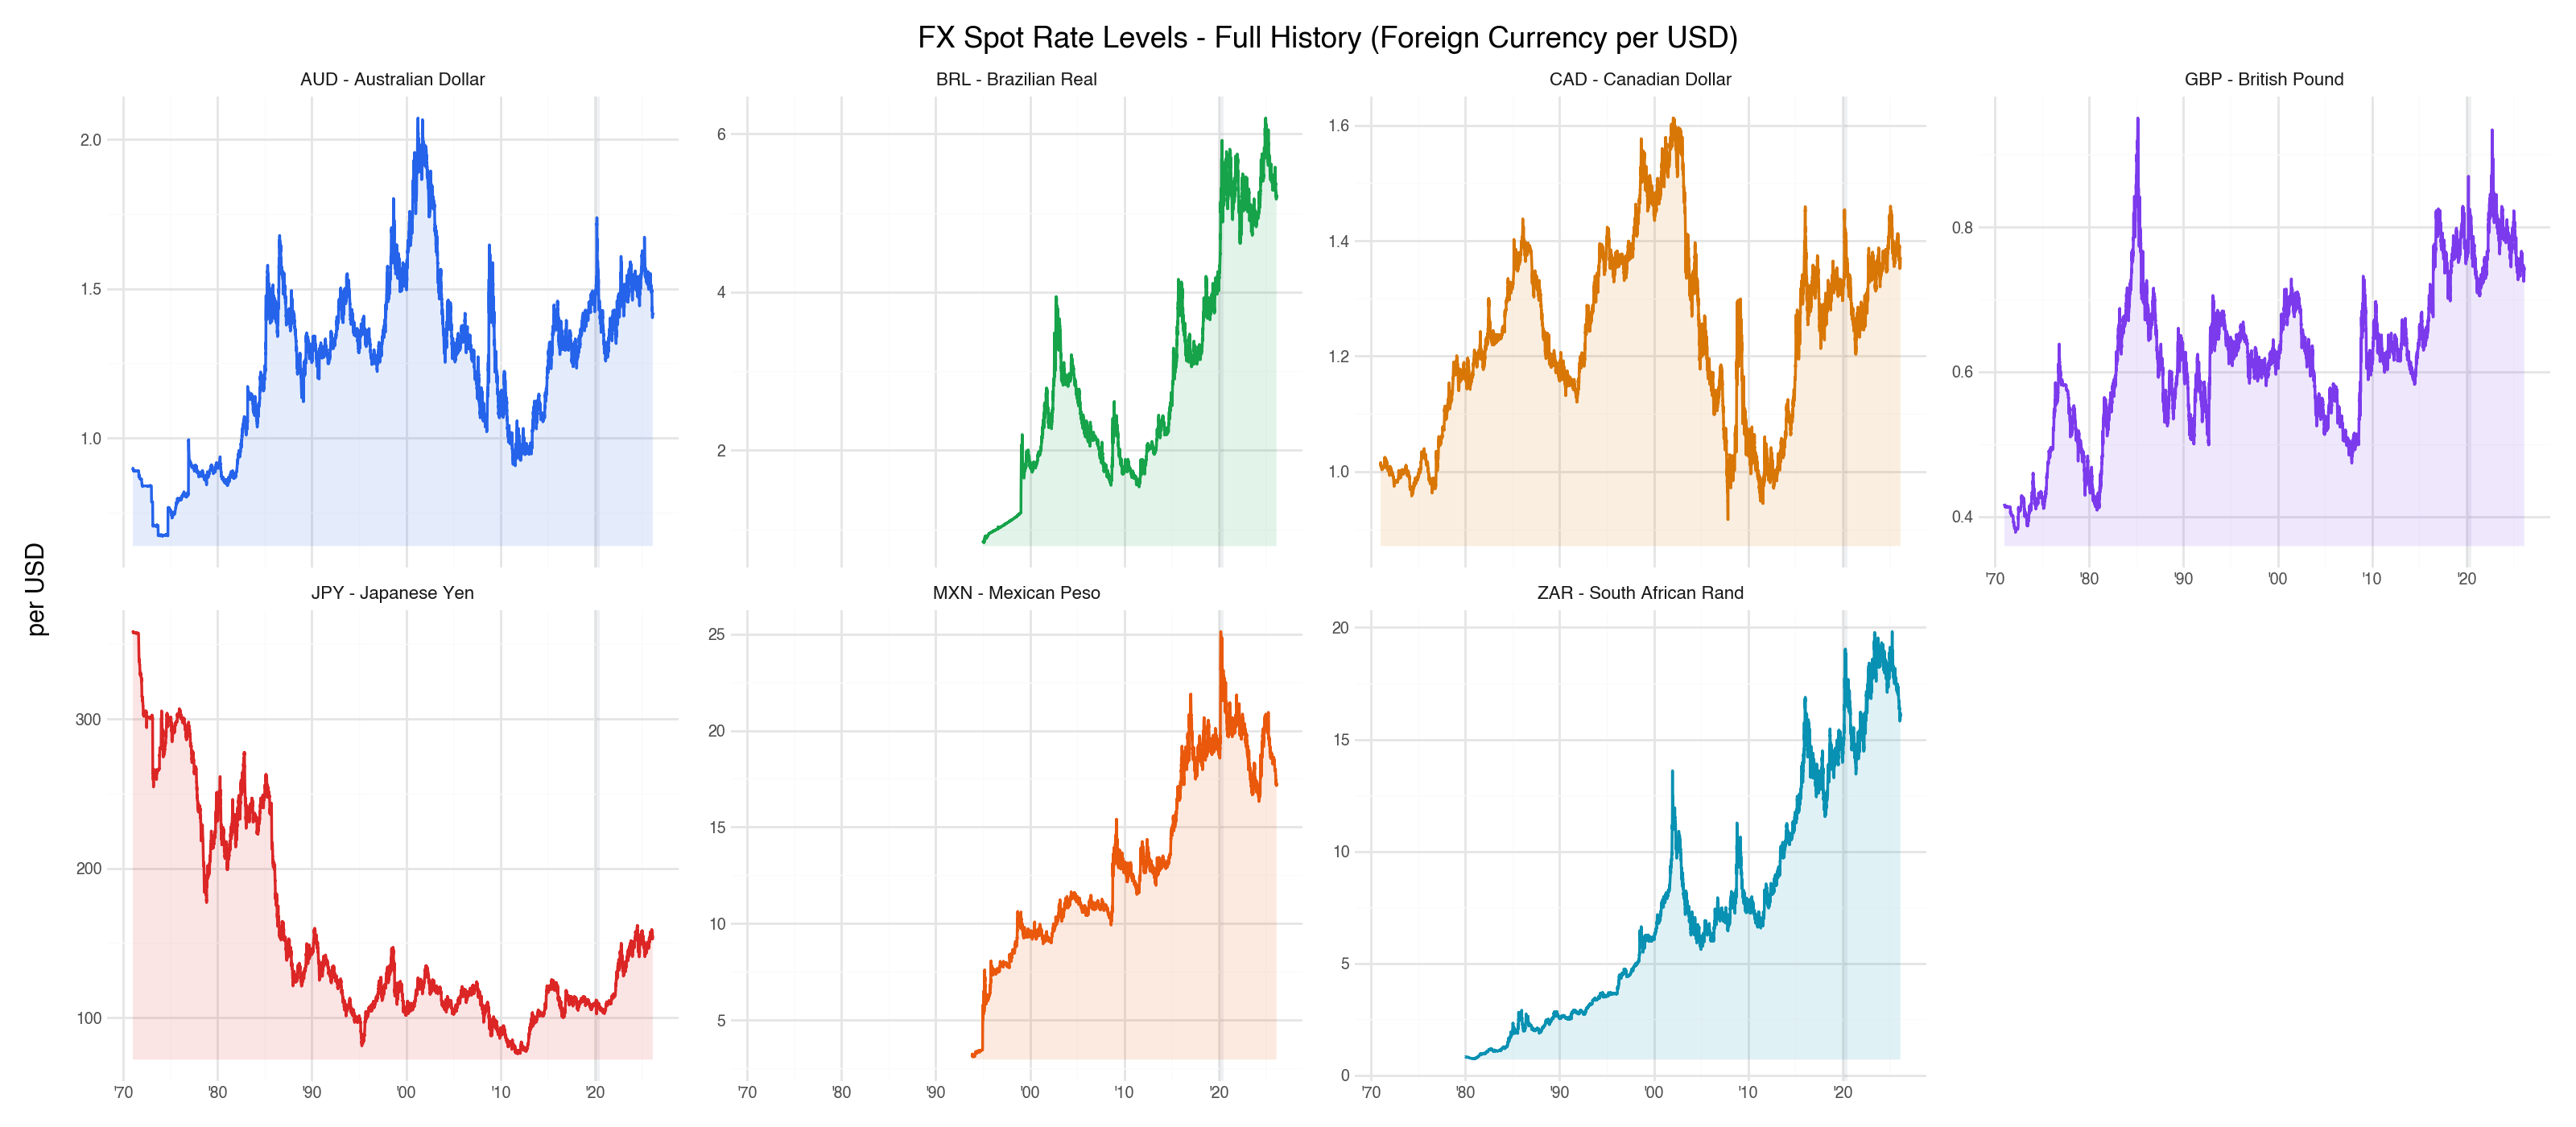

Plot: rolling_annualized_vol


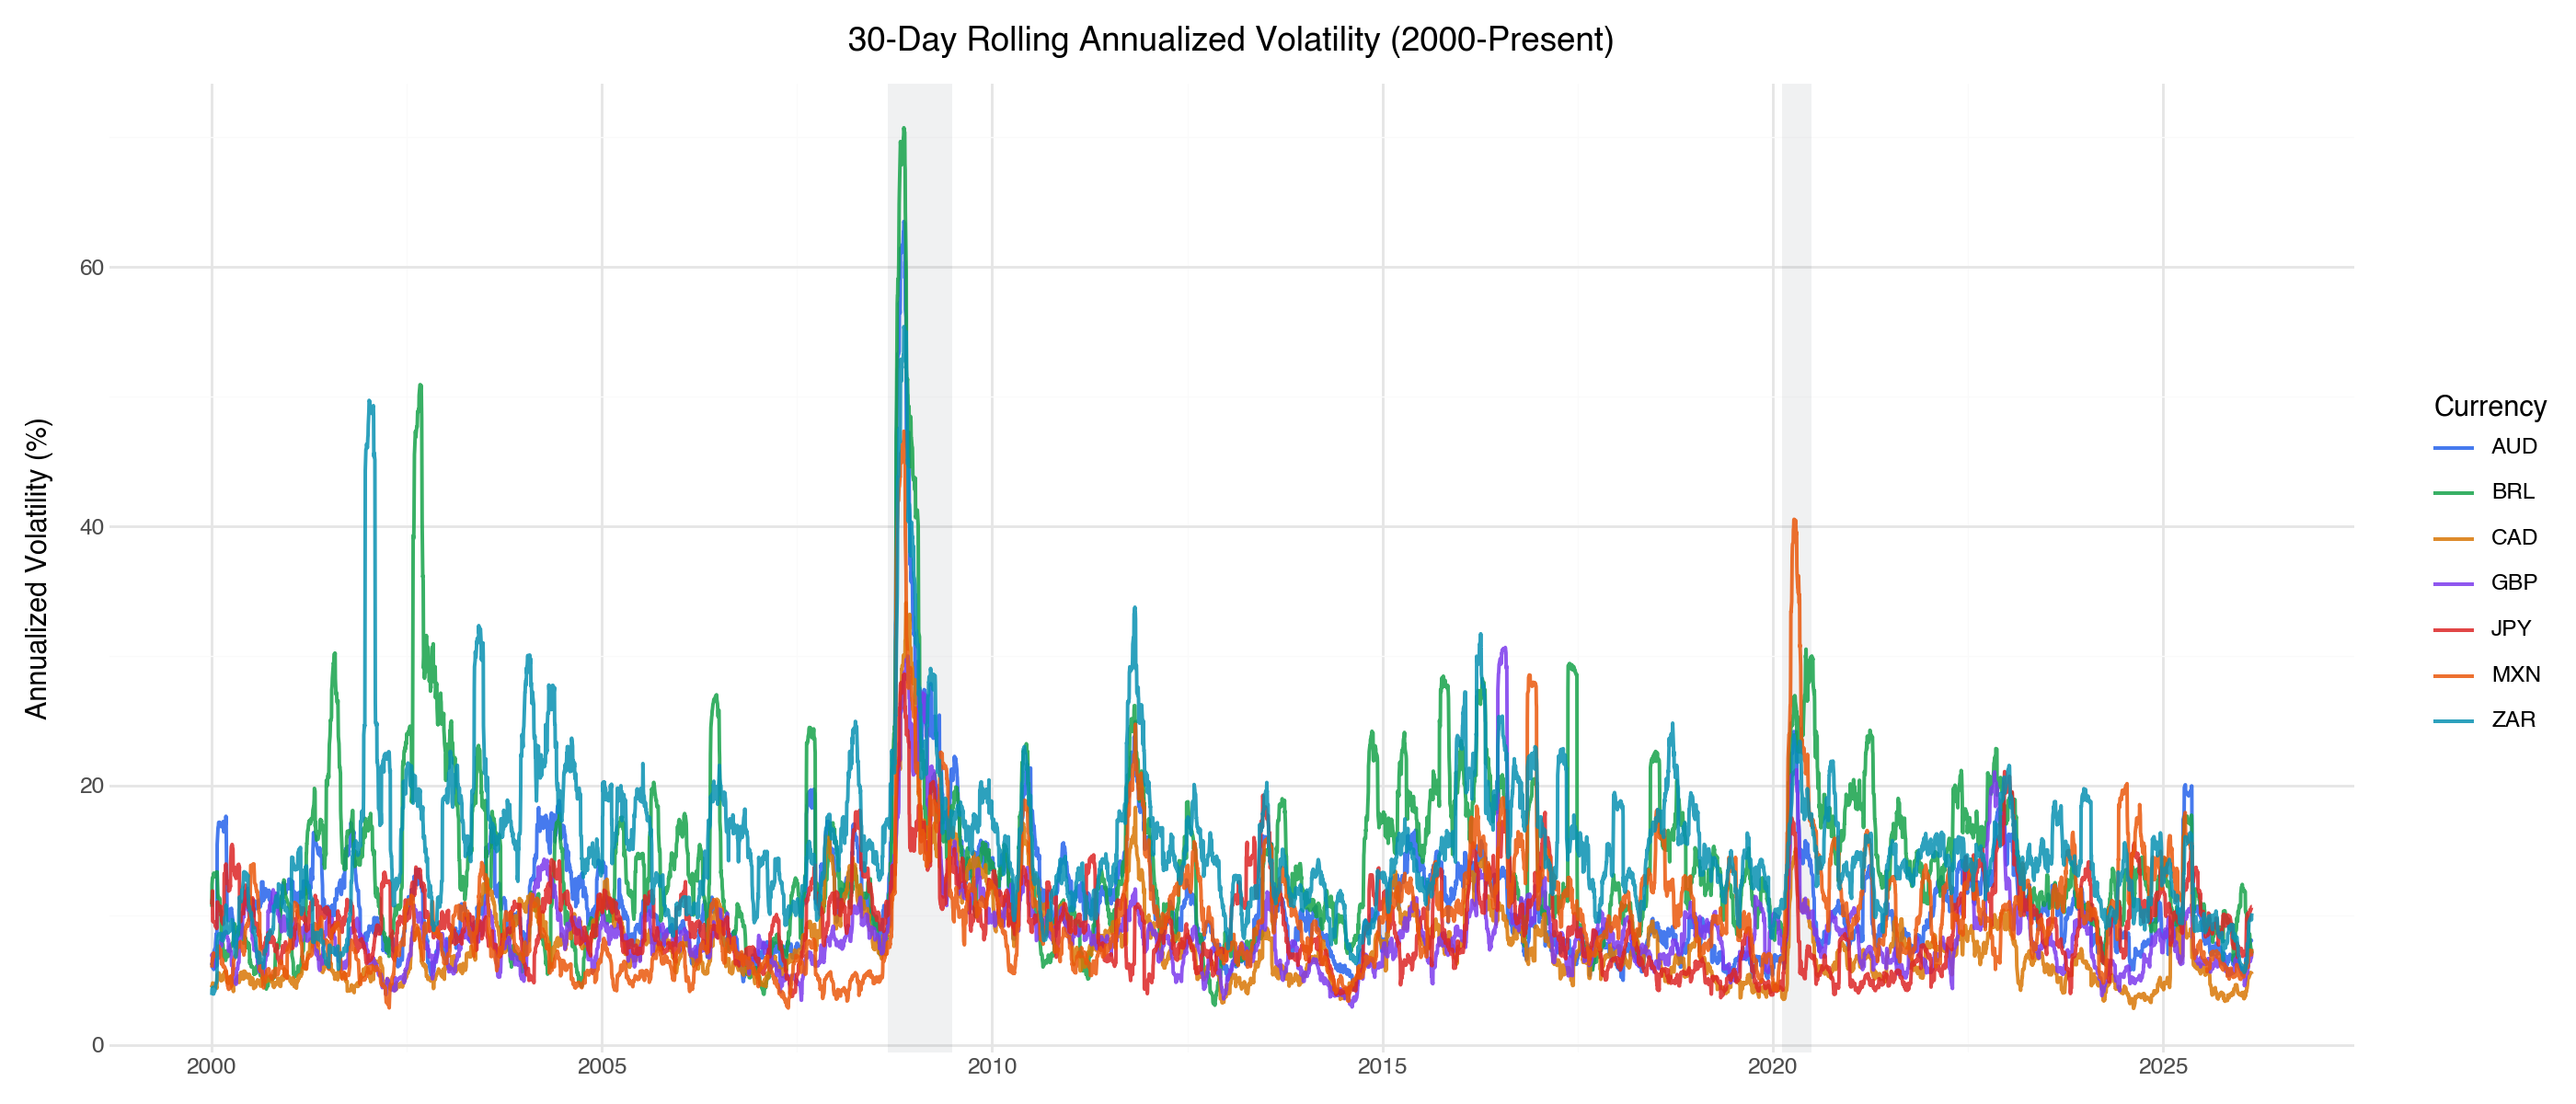

Plot: log_return_corr_heatmap


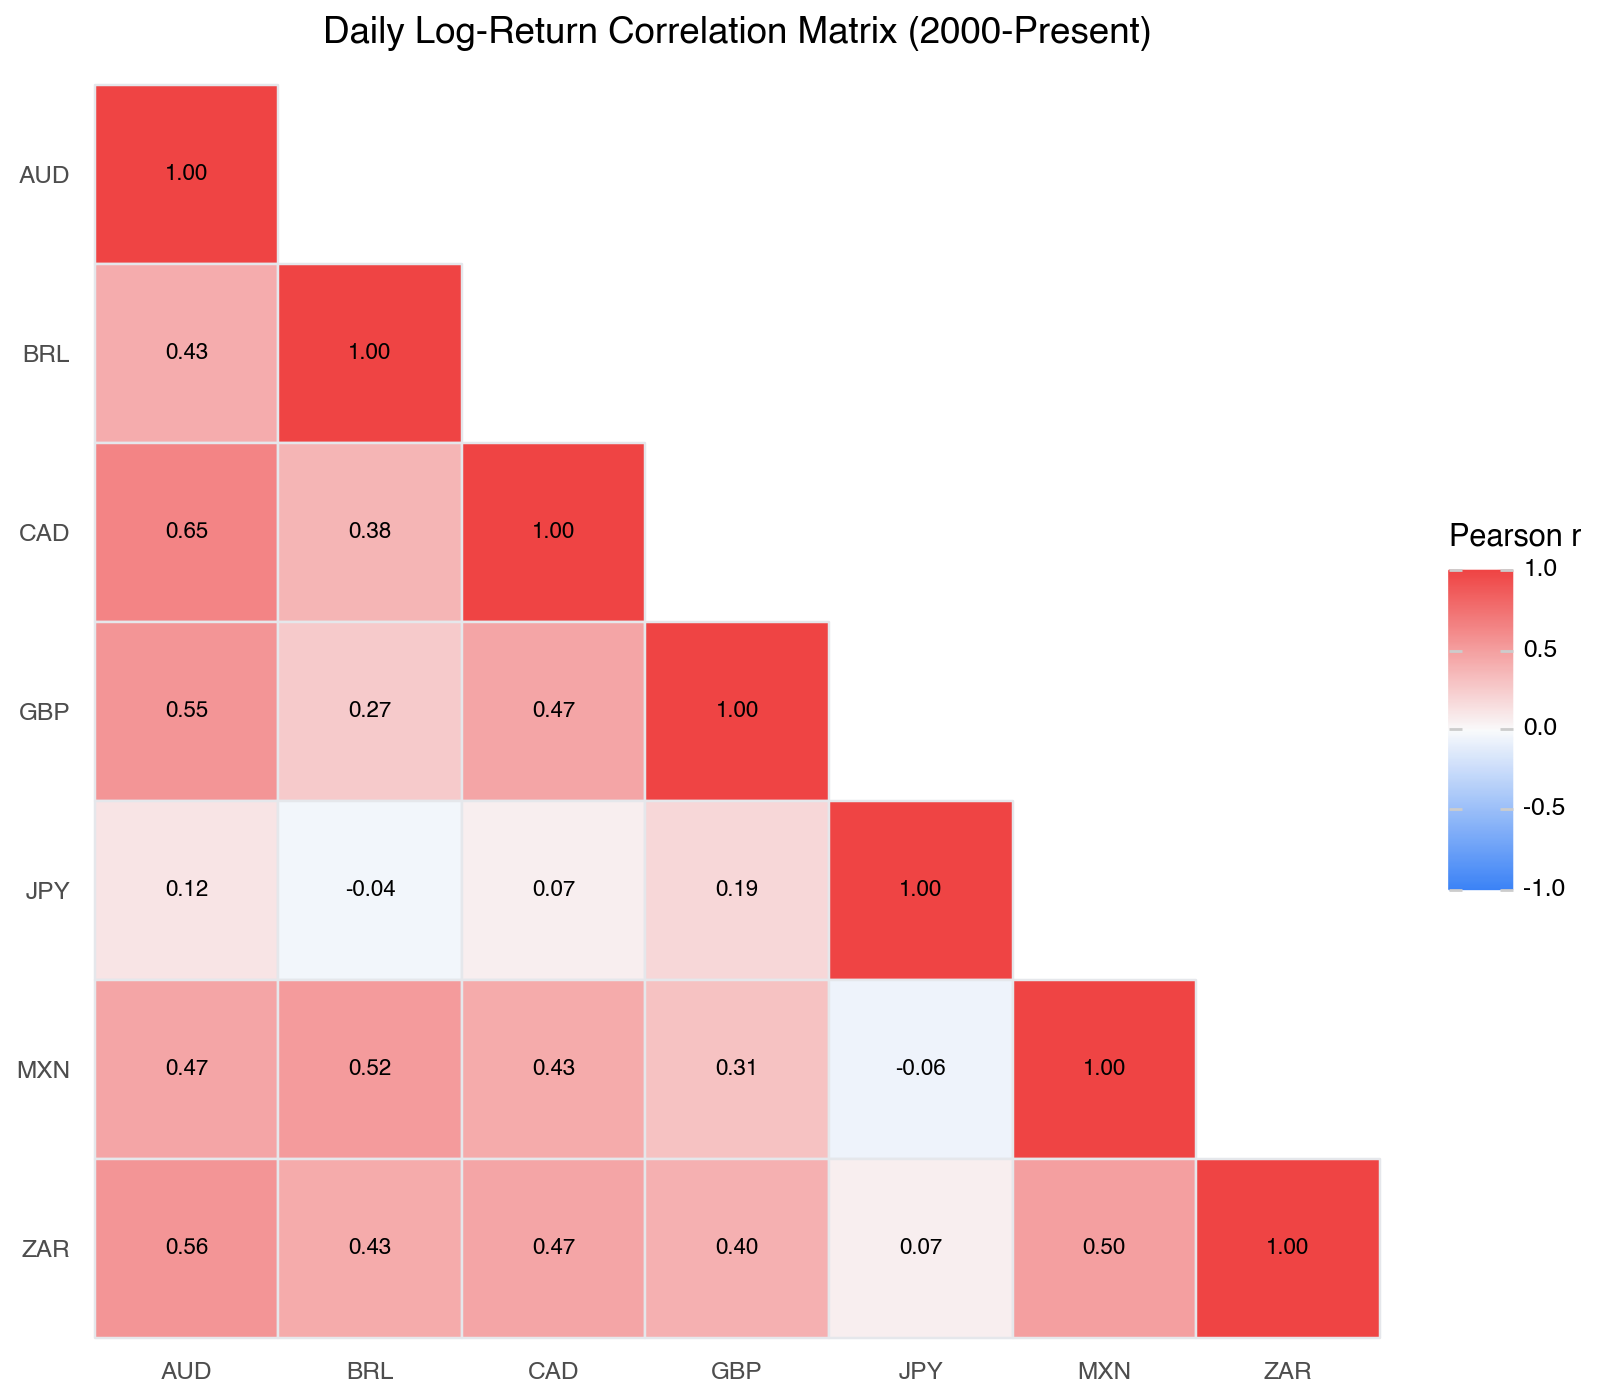

Plot: annual_return_heatmap


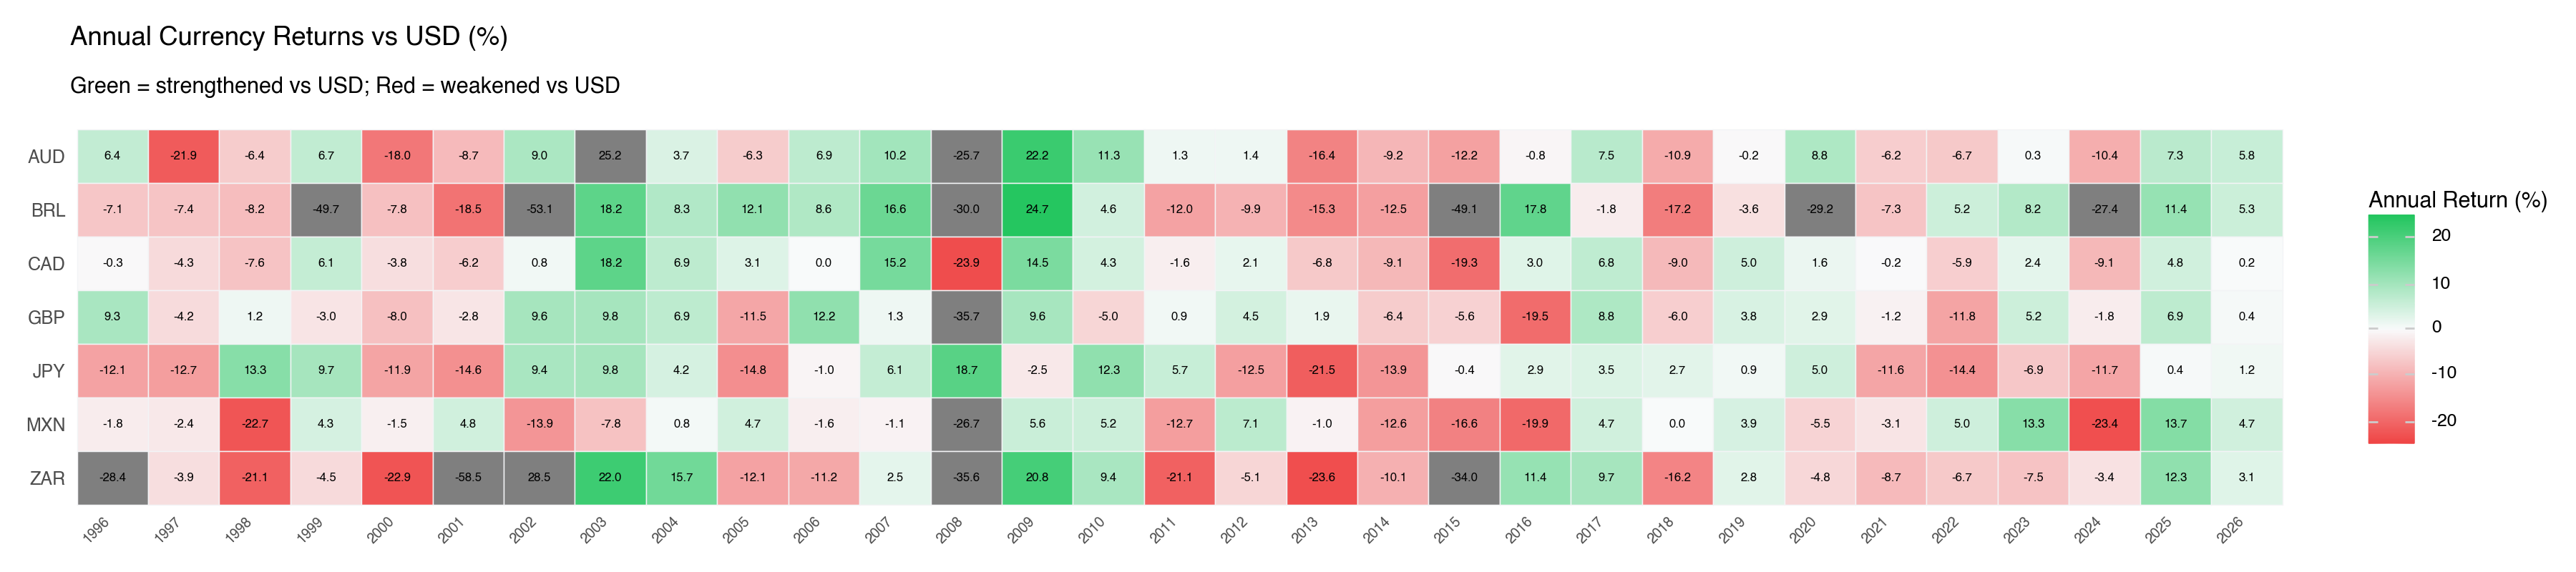

In [49]:
df = load_fx_spot()
plots = build_all_fx_spot_plots(df)
for plot_name, plot in plots.items():
    print(f"Plot: {plot_name}")
    display(plot)

In [50]:
eqy = pd.read_excel(DATA_DIR / "equity_indices.xlsx", parse_dates=["Dates"])
eqy = prepare_bbg_data(eqy)

eqy.head()

,MEXBOL Index,IBOV Index,JALSH Index,NKY Index,AS51 Index,SPTSX Index
date,,,,,,
2024-01-04,55406.96,131225.91,74522.49,33288.29,7494.098,20871.35
2024-01-05,56192.78,132022.92,74488.20,33377.42,7489.072,20937.55
2024-01-08,56175.68,132426.54,74103.23,33377.42,7451.548,21074.91
2024-01-09,55105.58,131446.59,73826.15,33763.18,7520.524,20970.98
2024-01-10,55318.67,130841.09,73586.98,34441.72,7468.459,20989.42


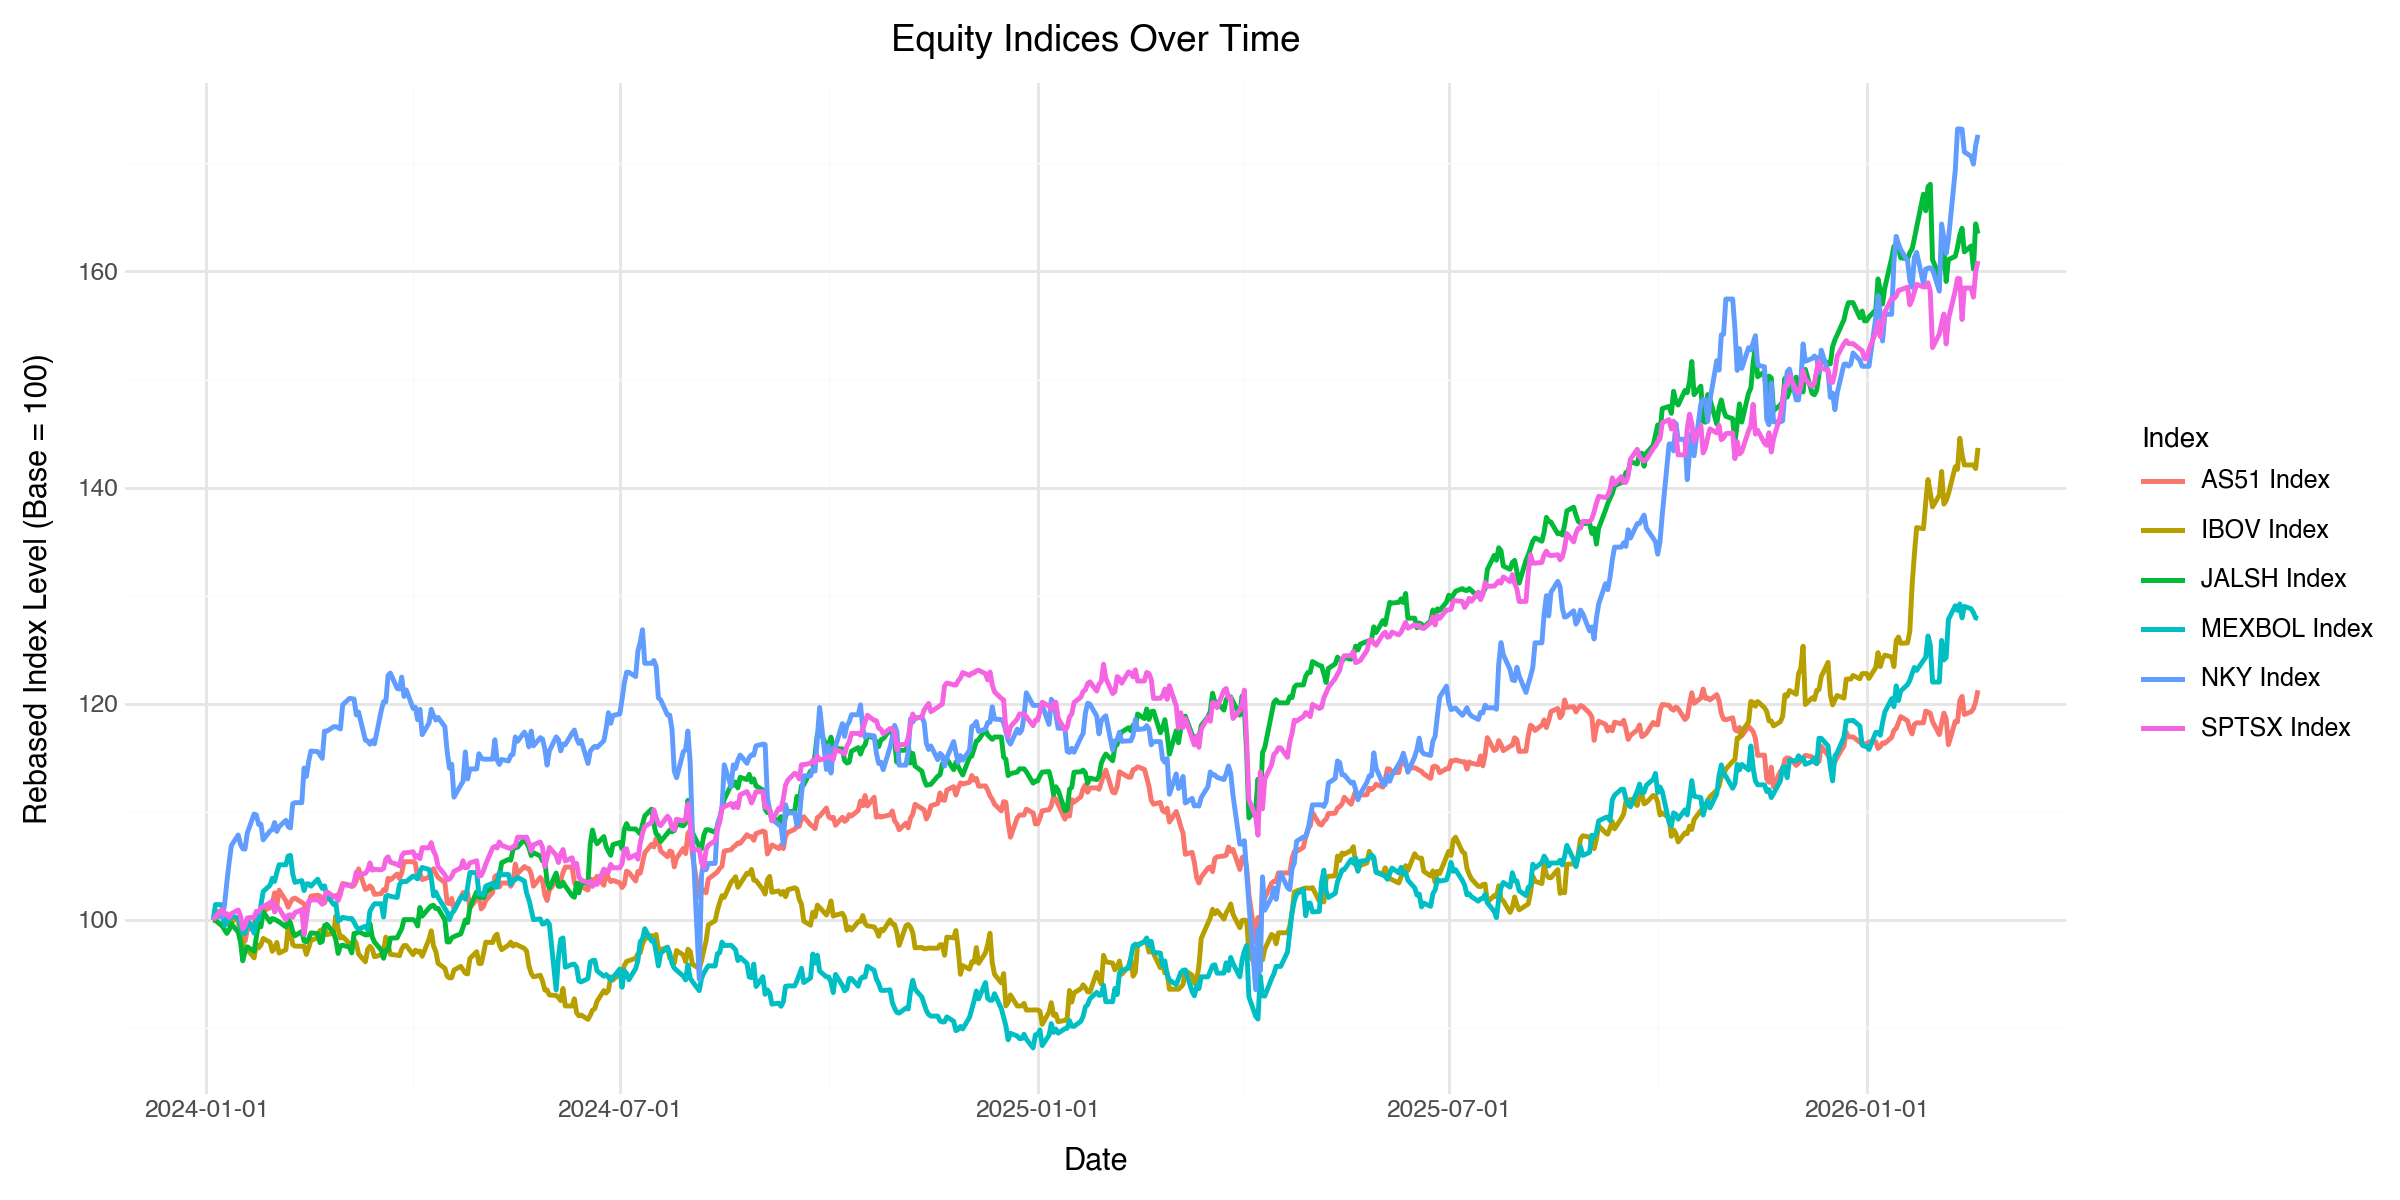

In [51]:
# Plot rebased equity indices
plot_rebased_equity_indices(eqy)

In [52]:
cds = pd.read_excel(DATA_DIR / "cds_5y_data.xlsx", parse_dates=["Dates"])
cds = prepare_bbg_data(cds)

cds.head()

,REPSOU CDS USD SR 5Y D14 Corp,BRAZIL CDS USD SR 5Y D14 Corp,MEX CDS USD SR 5Y D14 Corp,JGB CDS USD SR 5Y D14 Corp
date,,,,
2024-01-02,214.143,137.895,96.079,24.730
2024-01-03,227.705,141.471,99.000,24.730
2024-01-04,227.950,142.996,100.534,25.166
2024-01-05,223.464,141.496,98.884,24.825
2024-01-08,224.398,139.224,96.547,24.825


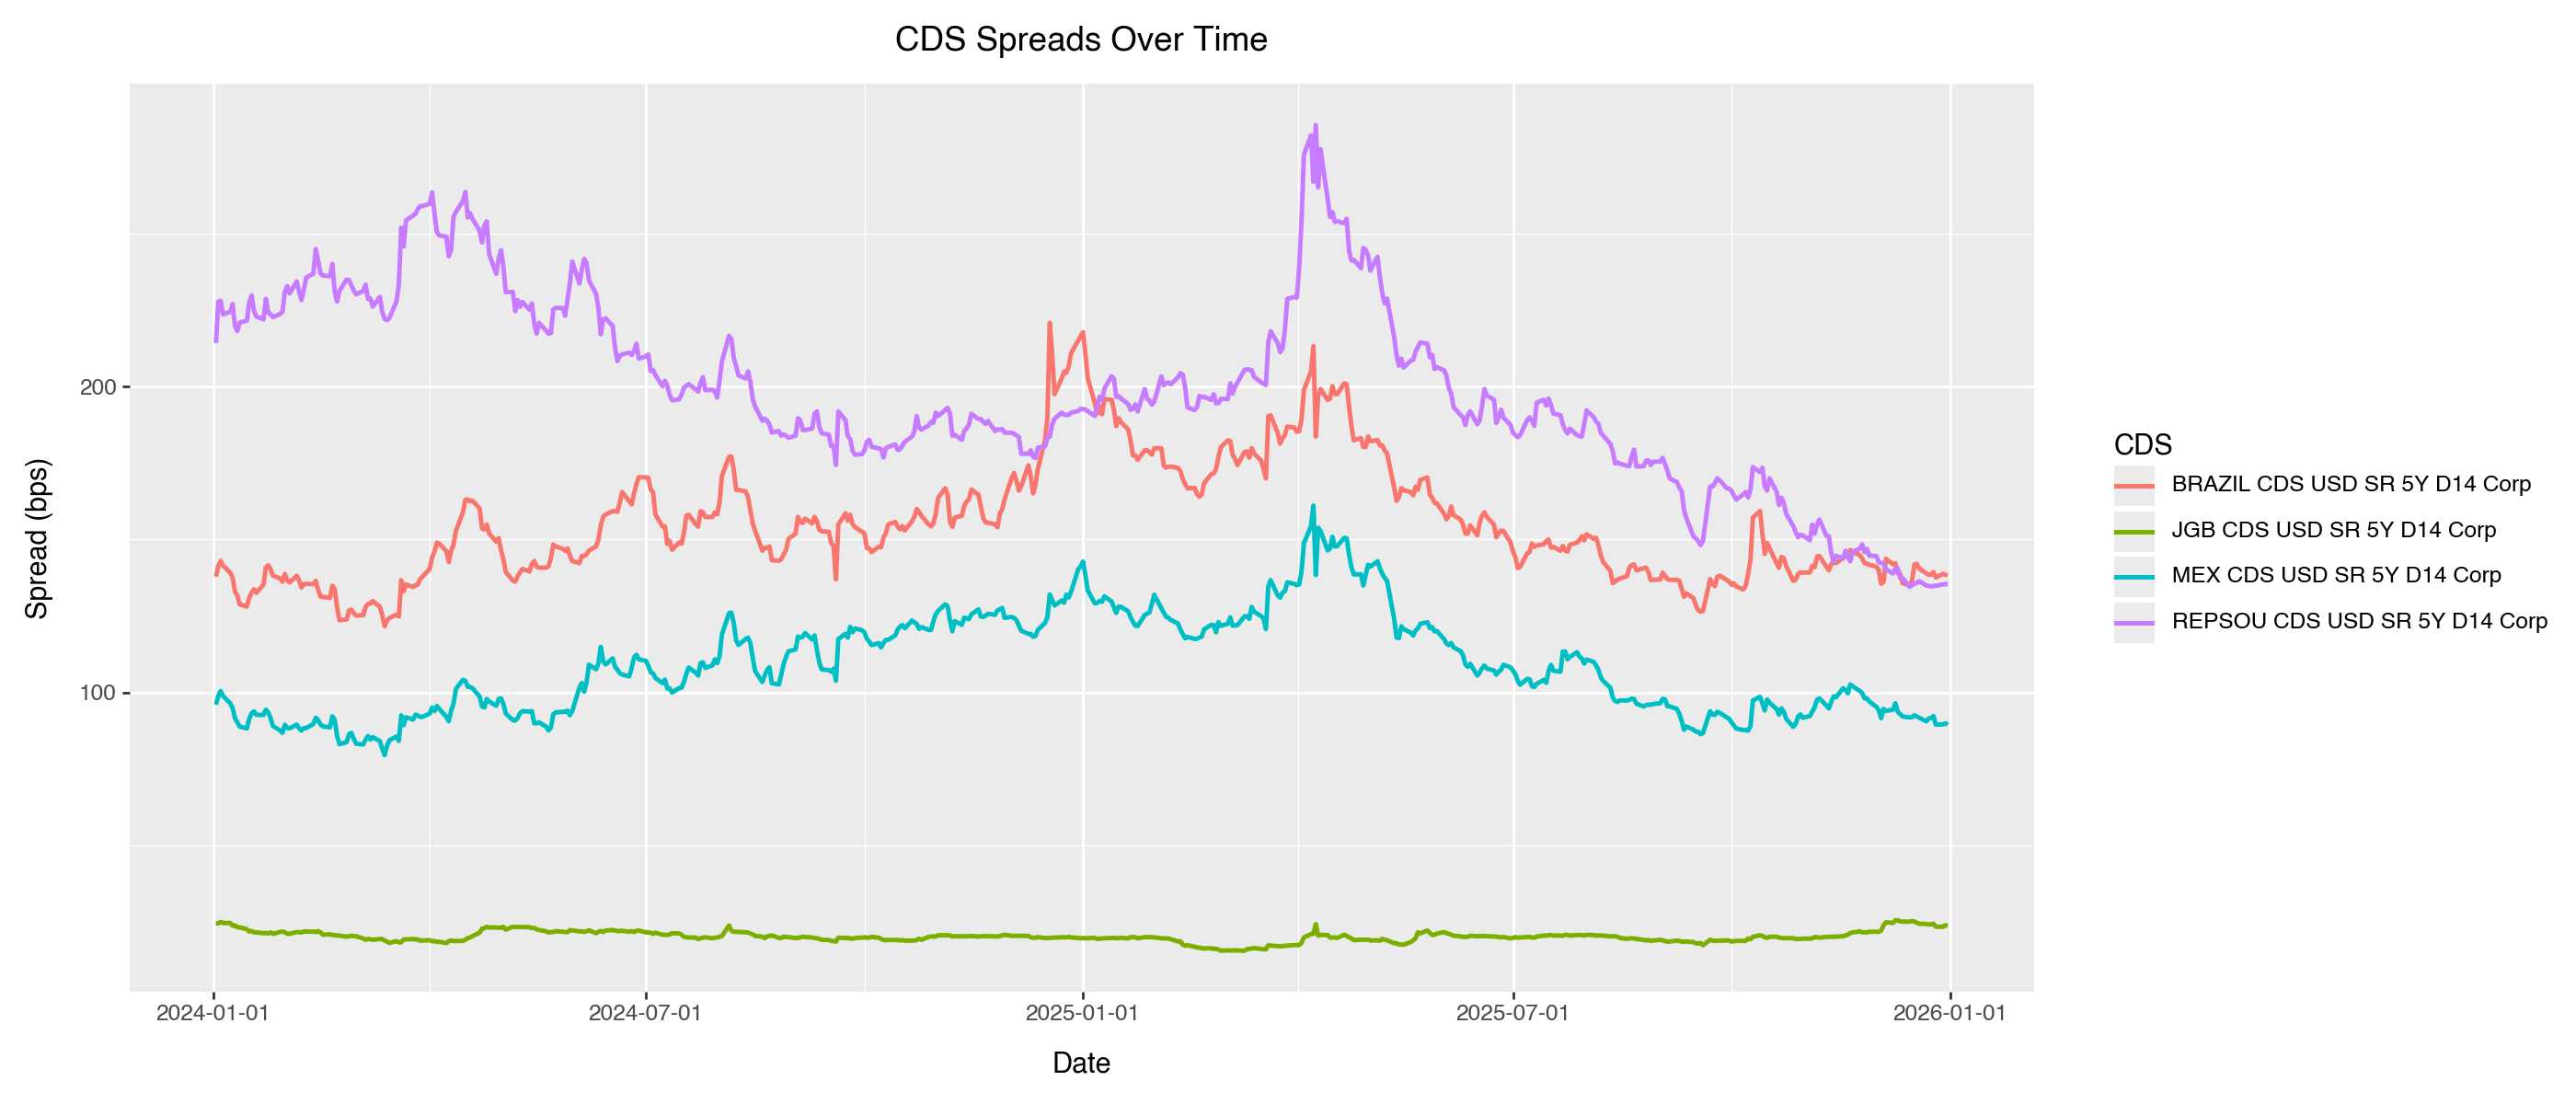

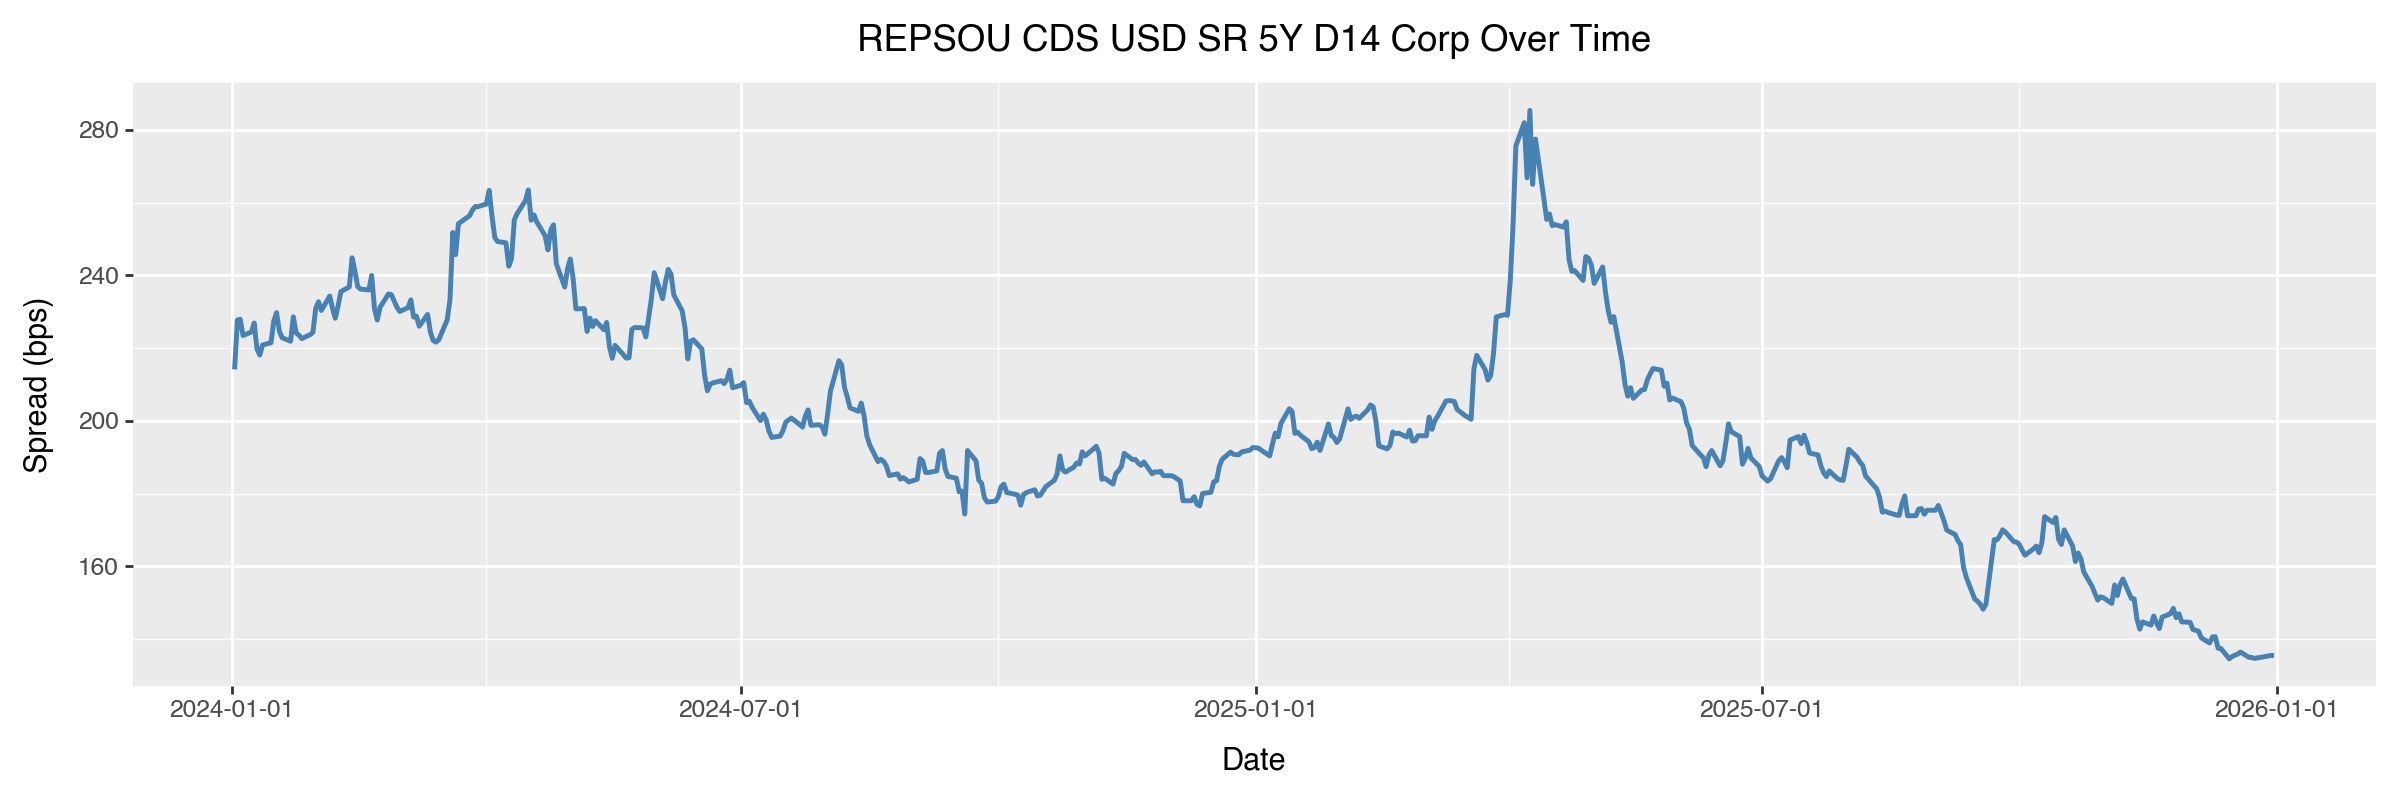

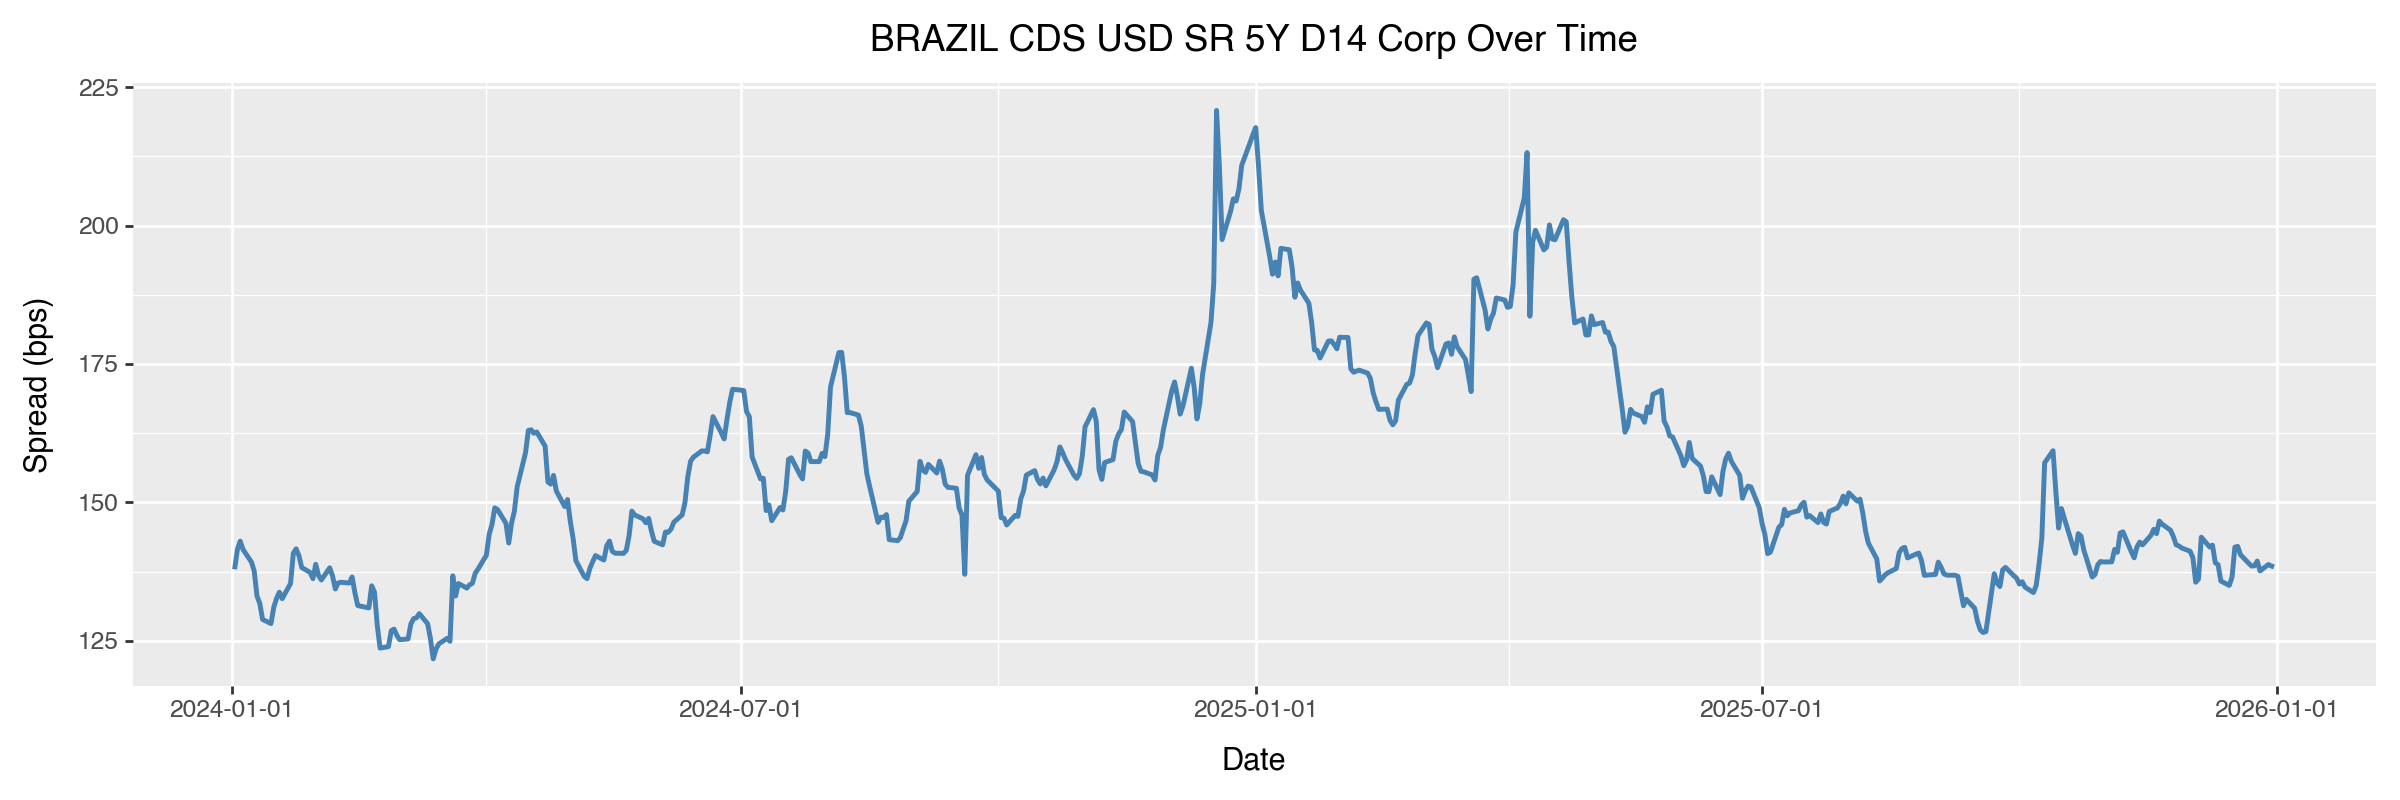

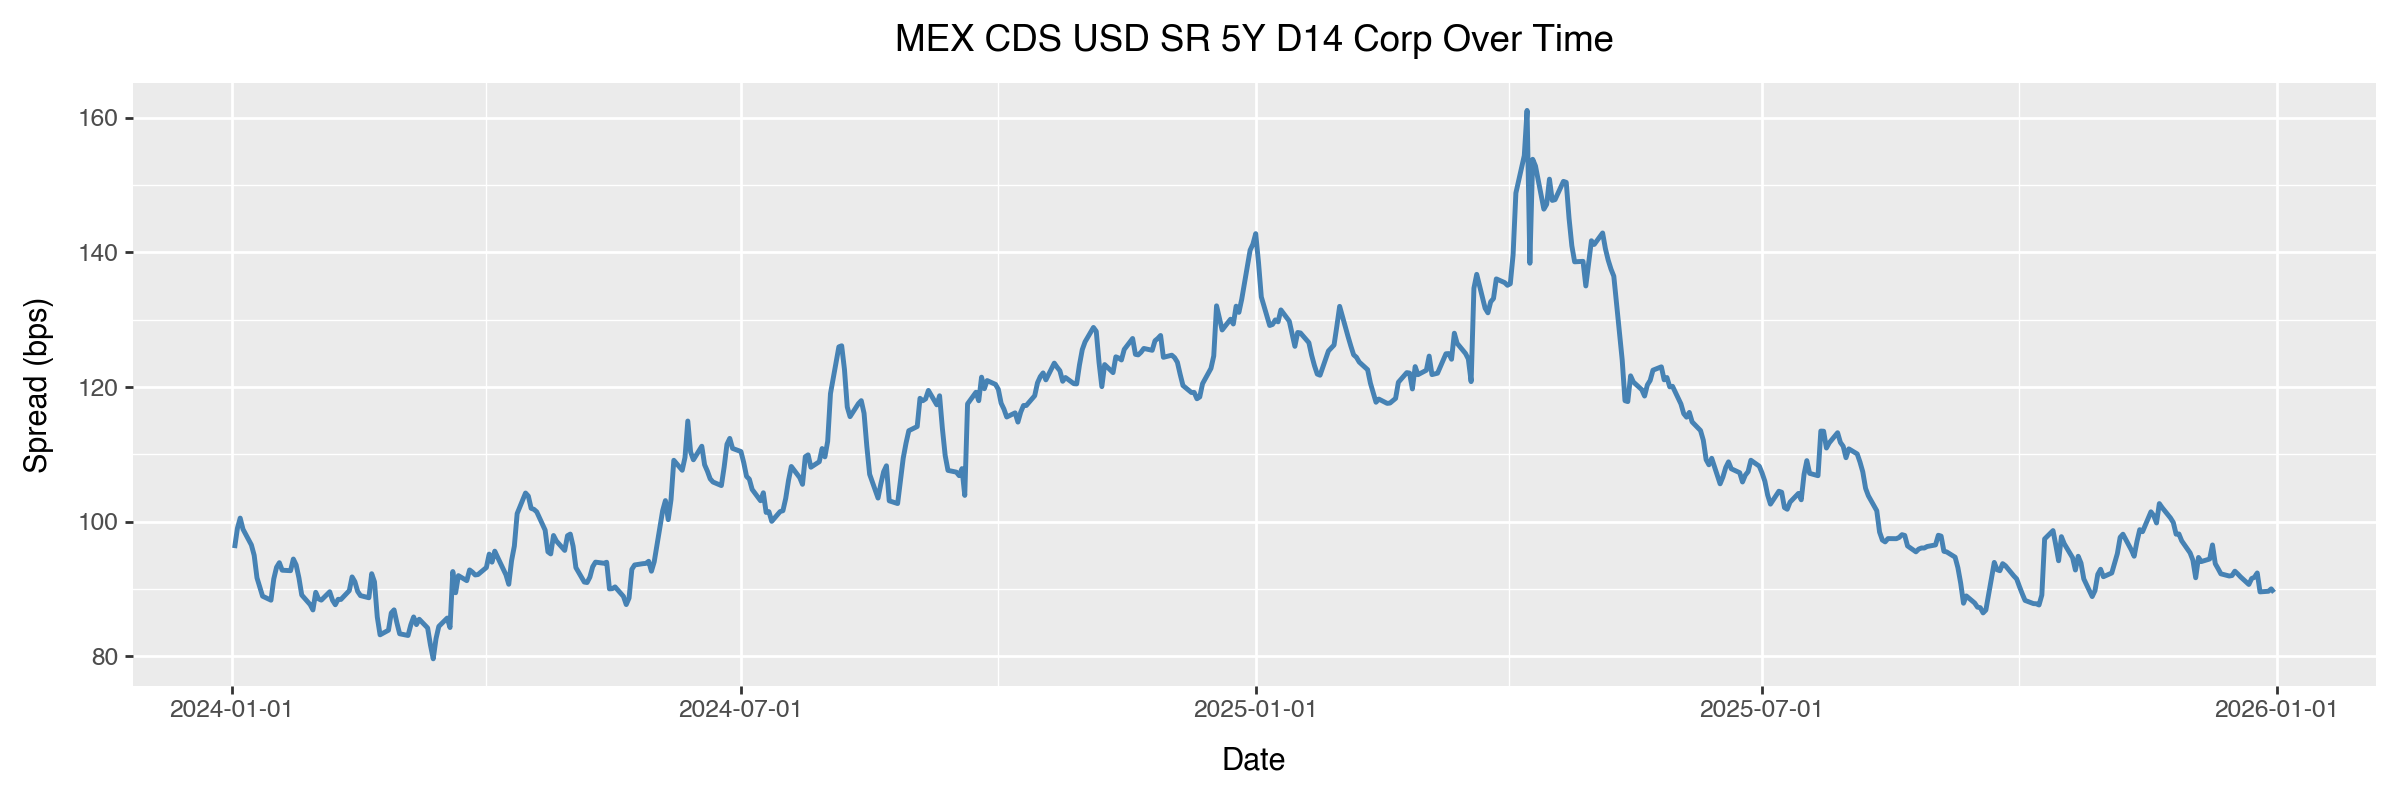

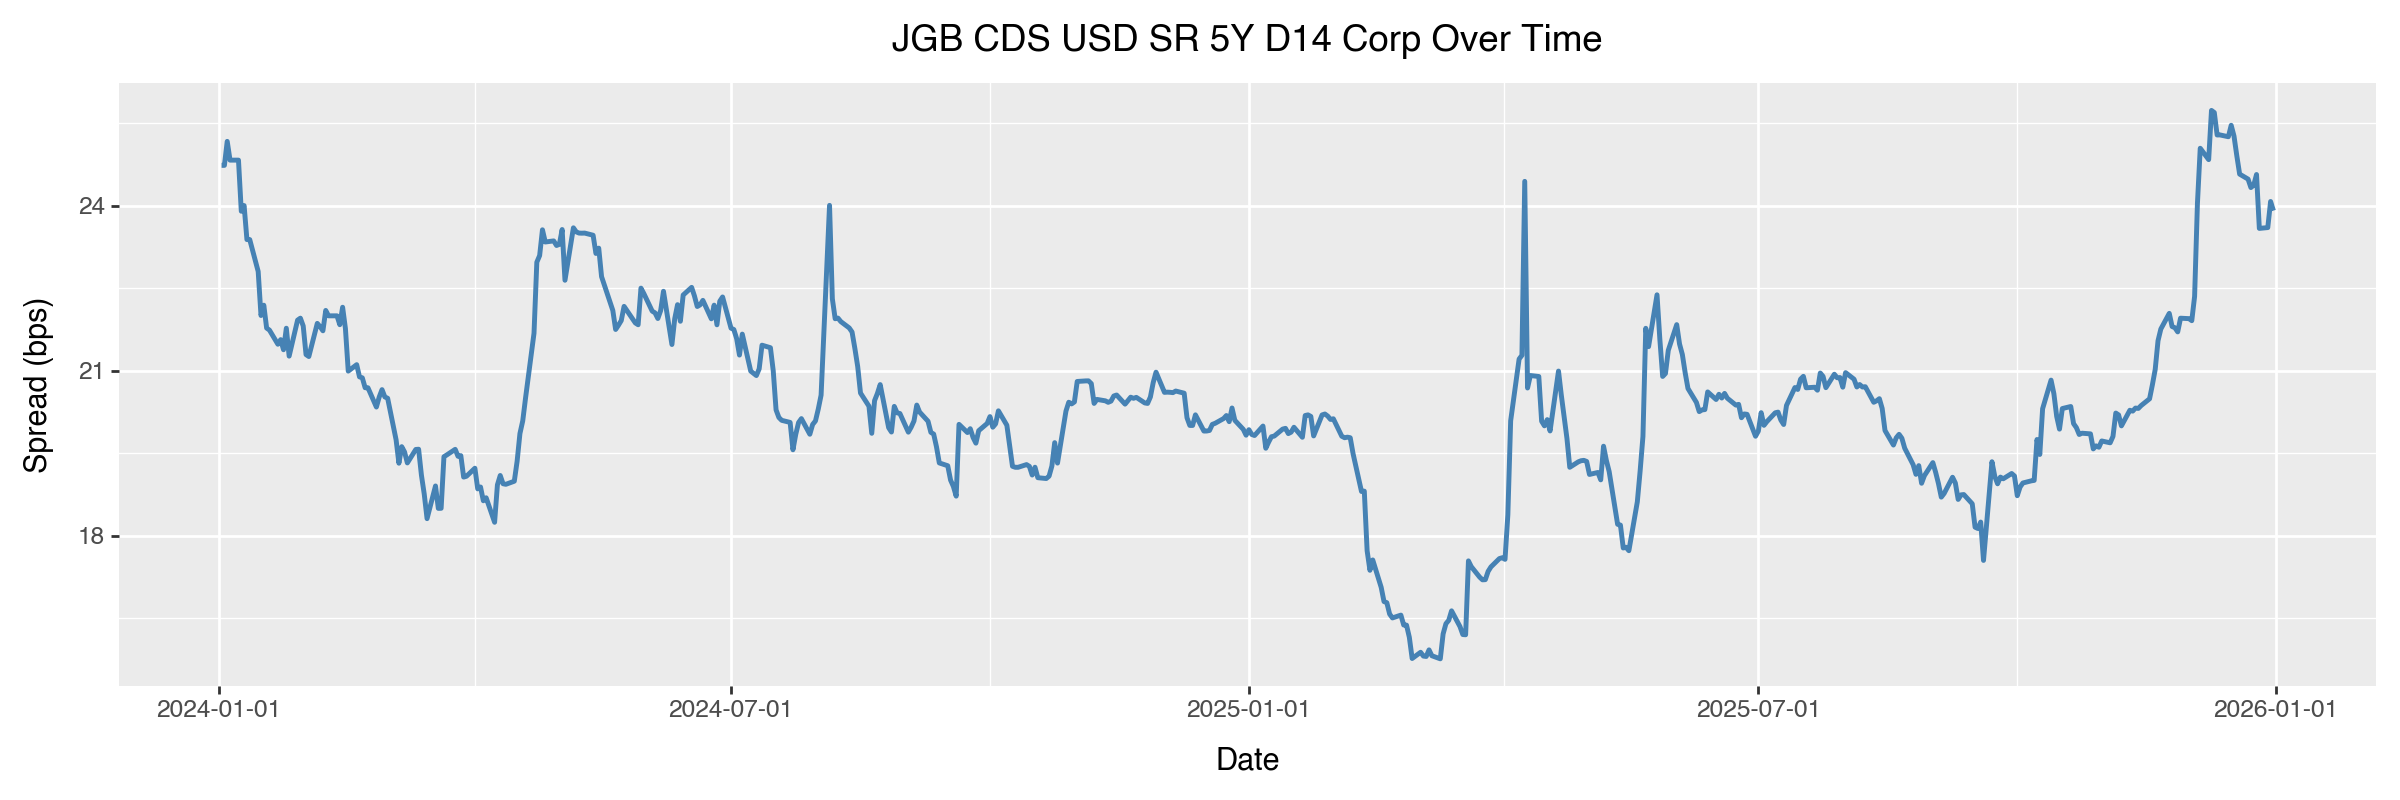

In [53]:
plot_cds_data(cds)

# 2. Trading Theory

Our strategy is grounded in two main trading hypotheses that reflect the cross-market dynamics between equity performance and currency movements, with particular attention to market liquidity and information flow.

### Hypothesis 1: Lead-Lag Relationship Between Equities and FX

The first hypothesis posits that a country’s major equities or stock indices exhibit a predictive relationship with the exchange rate of the corresponding currency, creating a lead-lag dynamic. The economic intuition stems from the portfolio reallocation mechanism:

- When domestic equities outperform relative to global markets, international investors seek exposure to capture the positive returns. Executing these transactions requires purchasing the local currency, generating demand that can drive appreciation.

- Equity markets often react faster to both domestic and global news than FX markets due to higher trading velocity, more immediate access to information, and higher concentration of informed participants. This difference in adjustment speed can create a predictable, short-term lead of equities over FX.

The lead-lag dynamic is reinforced by market microstructure frictions. FX markets, while large and liquid in aggregate, are fragmented, and institutional order execution may introduce delays in price adjustment. Moreover, large institutional investors may take more time to implement and execute rebalancing or investment ideas.

From a risk perspective, this lead-lag relationship reflects the fact that equities serve as an early signal of country-specific capital flow pressure. By monitoring excess returns in the equity market relative to macro-adjusted FX movements, we aim to extract a component of currency movements that is attributable specifically to anticipated capital flows, rather than broad macro shocks. This provides the foundation for a predictive signal in currency futures.

### Hypothesis 2: Lag Magnitude Depends on FX Market Liquidity
The second hypothesis extends the first by introducing a liquidity dimension. We expect that the observed lag between equity returns and FX adjustments will be longer in less liquid FX markets. The intuition for this hypothesis comes from the interaction of market microstructure and capital flow dynamics:

- In highly liquid FX markets (e.g., USD, EUR, JPY), large flows are more easily absorbed without significant price impact, and FX prices tend to adjust quickly to equity-driven demand. The lead-lag relationship is shorter and may be more difficult to exploit systematically.

- In less liquid markets, often associated with smaller economies or emerging markets, order flow from equity-driven capital reallocations can move exchange rates more slowly. FX participants may require time to absorb demand, and price discovery can be more gradual. This creates a longer and more exploitable lag in the relationship.

Liquidity effects also interact with investor behavior. In thin FX markets, foreign investors may need to stagger transactions to avoid excessive market impact, extending the time between equity signals and currency adjustment. Domestic investors, while facing lower transactional constraints, may still contribute to the lag if local FX depth is limited. Additionally, less liquid markets often exhibit higher transaction costs, wider bid-ask spreads, and more intermittent trading, all of which can amplify the persistence of the lead-lag dynamic.


# 3. Implementation

Our empirical framework implements a two-stage regression procedure designed to isolate the equity-driven component of currency movements after stripping out the common macro and risk factors that simultaneously affect FX markets. This hedging approach follows the empirical asset-pricing methodology used in the FX risk-premium literature, where systematic currency components (carry, dollar exposure, global risk) are first removed before testing new predictive signals (Lustig, Roussanov & Verdelhan, 2011; Menkhoff et al., 2012; Burnside et al., 2011).

---

### Stage 1: Hedging Out Macro and Risk Factors

In the first stage, we regress the daily excess return of each currency — defined as the spot return plus the daily forward implied yield — on three systematic factors:

FX Carry is measured as the daily forward implied yield for each currency pair, sourced directly from Bloomberg. The forward implied yield is annualized in the raw data; we convert it to a daily rate to construct the daily carry component of the excess currency return. Including carry controls for the well-documented carry trade premium embedded in FX returns, which would otherwise confound the equity-driven signal. The importance of the carry factor as a priced source of cross-sectional currency returns is established in Lustig, Roussanov & Verdelhan (2011), who show that high-interest-rate currencies load systematically on global risk factors.

Dollar Factor is defined as the cross-sectional average excess return across all currencies in the regression universe at time $t$. This factor captures the broad co-movement of all foreign currencies against the US dollar — movements driven by global dollar strength or weakness rather than country-specific dynamics. The construction follows the global dollar factor methodology in Lustig, Roussanov & Verdelhan (2011), where the average currency return represents a common component linked to global risk pricing. Formally, if $\mathcal{U}_t$ denotes the set of currencies in the universe at $t$:

$$\text{Dollar}_t = \frac{1}{|\mathcal{U}_t|} \sum_{i \in \mathcal{U}_t} r^{\text{excess}}_{i,t}$$

Sovereign CDS Spread (EM Markets) is included for emerging market currencies to control for country-specific credit risk and macro distress. CDS spreads on 5-year sovereign debt (sourced from Bloomberg) capture fiscal and geopolitical risk premia embedded in emerging market currencies, which are not adequately reflected in developed-market factors alone. The inclusion of credit risk proxies aligns with the evidence in Menkhoff et al. (2012), who show that currency excess returns are strongly related to global volatility and risk conditions, and with Burnside et al. (2011), who emphasize that currency premia reflect compensation for exposure to systematic risk factors rather than pure arbitrage.

The first-stage regression for currency $i$ at time $t$ is:

$$r^{\text{excess}}_{i,t} = \alpha_i + \beta_1 \cdot \text{Carry}_{i,t} + \beta_2 \cdot \text{Dollar}_t + \beta_3 \cdot \Delta\text{CDS}_{i,t} + \varepsilon_{i,t}$$

The residual $\hat{\varepsilon}_{i,t}$ — the unexplained alpha from this first regression — represents the component of the currency’s excess return that is orthogonal to carry, broad dollar movements, and sovereign credit risk. This residualization step mirrors the two-pass asset pricing methodology commonly used in international finance to isolate incremental pricing information beyond known risk factors (Lustig, Roussanov & Verdelhan, 2011; Burnside et al., 2011).

---

### Stage 2: Predictive Regression on Equity Signals

The second stage implements a predictive regression that tests whether foreign equity outperformance leads excess currency returns. Our theory holds specifically in the regime where the foreign equity market outperforms the domestic (US) market: when global investors are drawn into a foreign market by strong relative equity performance, their capital inflows generate demand for the local currency.

Accordingly, the explanatory variable $X_{i,t}$ in Stage 2 is the excess return of the foreign equity index over the S&P 500 (SPY) at time $t$:

$$X_{i,t} = r^{\text{equity}}_{i,t} - r^{\text{SPY}}_t$$

Equity returns are computed close-to-close using daily index prices sourced from Bloomberg. The dependent variable $Y_{i,t}$ is the Stage 1 residual $\hat{\varepsilon}_{i,t+1}$ — the unexplained currency excess return at time $t+1$, one period ahead. This timing convention is critical: equity information observed at the close of day $t$ is used to predict currency returns at $t+1$, strictly enforcing no lookahead bias.

The Stage 2 predictive regression is:

$$\hat{\varepsilon}_{i,t+1} = \gamma_i + \delta_i \cdot X_{i,t} + \nu_{i,t}$$

This regression is the **foundational trading signal** of the strategy. A statistically significant positive estimate of $\hat{\delta}_i$ indicates that days on which the foreign equity market outperforms the S&P 500 are predictive of above-average excess currency returns the following day, after controlling for macro risk factors. The estimated coefficient $\hat{\delta}_i$ and its associated $t$-statistic serve as the primary measure of signal strength for each currency in the universe.

The two-stage design ensures that the equity-FX relationship estimated in Stage 2 is not contaminated by carry dynamics, dollar factor exposure, or sovereign credit risk — all of which represent alternative explanations for co-movement between equity and currency markets documented in the FX risk-premium literature (Lustig, Roussanov & Verdelhan, 2011; Menkhoff et al., 2012; Burnside et al., 2011).

# 4. Signal Evaluation (Backtesting)

We evaluate the predictive signal from Stage 2 through a systematic backtesting framework, using **FX futures** as the tradable instrument rather than the FX spot market directly.

---

### Instrument Choice: FX Futures

Backtesting directly on FX spot presents several practical challenges, including difficulties capturing realistic transaction costs, funding rates, roll conventions, and the mechanics of leveraged currency positions. To address these issues, we obtain exposure to the Stage 2 signal through standardized **CME FX futures contracts**, which offer:

- Transparent exchange-listed pricing with well-defined contract specifications
- High liquidity during regular US trading hours and near-continuous trading (23 hours per day)
- Consistent roll schedules and publicly available contract data
- Realistic transaction cost modeling via bid-ask spreads and commission estimates

FX futures data is sourced from the CME and covers the contracts corresponding to each currency in the universe (GBP, JPY, AUD, CAD, MXN, BRL, ZAR futures where available). This directly maps our statistical signal to a tradable implementation.

---

### Signal Generation and Trade Timing

The strategy adheres to strict timing discipline to reflect realistic execution:

**Signal generation** occurs at the **close of day $t$**. Using that day's closing equity prices and the factors estimated from Stage 1, we generate the Stage 2 fitted value $\hat{\delta}_i \cdot X_{i,t}$ as the signal for each currency. This is the forecast of the residual excess FX return for the following day.

**Trade execution** occurs at the **open of day $t+1$**. Because CME FX futures trade for approximately 23 hours per day, positions can be initiated shortly after the equity close on day $t$ — effectively at the start of the futures trading session for $t+1$. This near-continuous market access means the lag between signal generation and trade entry is minimal, reducing the risk of signal decay.

The position in currency $i$'s futures contract at time $t$ is determined by the sign and magnitude of the signal:

$$\text{Position}_{i,t} = f\!\left(\hat{\delta}_i \cdot X_{i,t}\right)$$

where $f(\cdot)$ maps the signal to a long, short, or flat position. In the baseline specification, we use a directional (sign-based) rule: go long the futures when the signal is positive, short when negative. Extensions consider signal-scaled sizing where position notional is proportional to signal strength.

---

### Backtesting Framework

The backtesting procedure evaluates the strategy over the full sample period with the following key design choices:

**Walk-forward validation** is used to guard against in-sample overfitting. The regression coefficients $\hat{\delta}_i$ are estimated on an expanding or rolling window of historical data, and signals are generated only using information available at the time of the trade.

**Transaction costs** are applied to each position change, reflecting realistic round-trip costs for CME FX futures (bid-ask spread plus exchange fees). These costs are particularly relevant for high-turnover signals.

**Contract rolls** are handled by closing positions in the expiring contract and re-establishing them in the next front-month contract prior to delivery, following standard futures roll conventions. The timing of rolls is chosen to avoid illiquid periods near expiry.

**Performance metrics** used to evaluate the strategy include annualized Sharpe ratio, cumulative return, maximum drawdown, and per-currency information coefficient (IC) between the signal and realized next-day futures returns. A positive and statistically significant IC confirms that the Stage 2 regression signal carries genuine out-of-sample predictive power.

# References

Burnside, C., Eichenbaum, M., Kleshchelski, I., & Rebelo, S. (2011). *Do Peso Problems Explain the Returns to the Carry Trade?* Journal of Finance, 66(3), 853–891.

Lustig, H., Roussanov, N., & Verdelhan, A. (2011). *Common Risk Factors in Currency Markets.* Review of Financial Studies, 24(11), 3731–3777.

Menkhoff, L., Sarno, L., Schmeling, M., & Schrimpf, A. (2012). *Carry Trades and Global Foreign Exchange Volatility.* Journal of Finance, 67(2), 681–718.

Hau, H. & Helene, R. (2006). *Exchange Rates, Equity Prices, and Capital Flows.* The Review of Financial Studies, 19(1), 273-317.

Hasselgren, A., Peltomäki, J., & Graham, M. (2020). *Speculator activity and the cross-asset predictability of FX returns.* International Review of Financial Analysis, 72
